# OpenStreetMap Data Wrangling with SQLite

## Project Overview

To choose any area of the world in https://www.openstreetmap.org and use data wrangling techniques, such as assessing the quality of the data for validity, accuracy, completeness, consistency and uniformity, to clean the OpenStreetMap data for that part of the world. Finally, use SQLite as the data schema to complete the project by storing, querying and aggregating the data.

## Choice of tools

The following was used for this project:
<ul>
<li>Keep basic documentation and notes in Jupyter Notebook</li>
<li>Save files in Github</li>
<li>Use DB Browser for SQLite as SQL environment (in combination with command line) for testing and exploration</li>
<li>Having all SQL operations done via python using the sqlite API</li>
</ul>

## OSM Dataset

The data area selected for this project is of the Phoenix Metroplex, Arizona. This area was chosen primarily because I currently live there.  I would like to work with large datasets to learn and help others gain insights from the data. This is a great start towards that goal.

Data was directly exported from OpenStreetMap and Overpass-API:
<ul>
<li>

<a href="https://www.openstreetmap.org/export#map=10/33.5128/-111.9466">https://www.openstreetmap.org/export#map=10/33.5128/-111.9466</a>

</li>
</ul>

## Phoenix Metroplex
<ul>
<li>

<a href="https://en.wikipedia.org/wiki/Phoenix_metropolitan_area">https://en.wikipedia.org/wiki/Phoenix_metropolitan_area</a>
<!--
<a href="https://en.wikipedia.org/wiki/Apache_Junction,_Arizona">https://en.wikipedia.org/wiki/Apache_Junction,_Arizona</a>
-->
</li>
</ul>



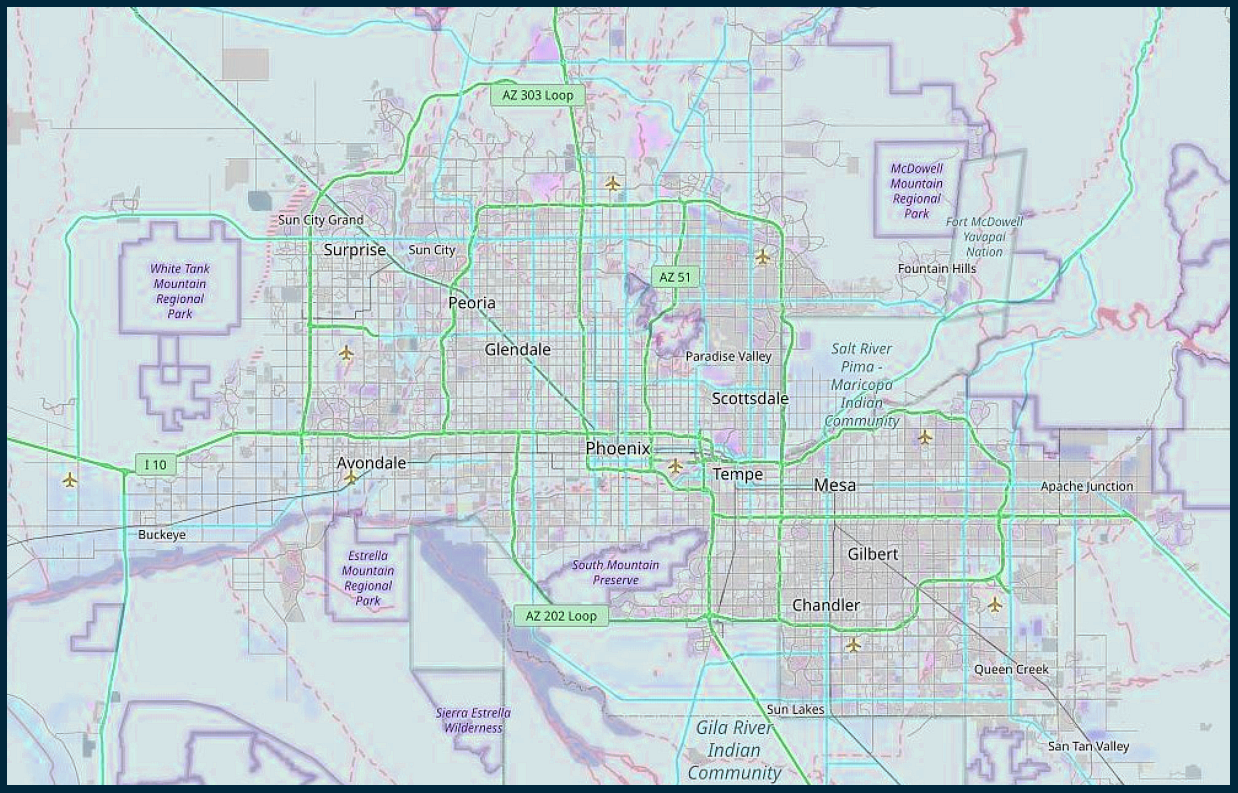

In [1]:
from IPython.display import Image
#Image("https://upload.wikimedia.org/wikipedia/commons/5/53/AJ_OSM2.png", width ="500", height = "250")
Image("https://upload.wikimedia.org/wikipedia/commons/a/a6/Phoenix_Metro_OSM.png", width ="500", height = "250")

## Data Audit

### Issues Encountered in the Map Data

Prior to working with the entire dataset an initially review/investigation of a sample set of the data was performed. I noticed three main problems with the sample data. Each data problem will be highlighted below.
<ul>
<li>Abbreviated street names (St. for Street)</li>
<li>Ambiguous abbreviation (St. for Street vs St. for Saint)</li>
<li>Multiple abbreviations in values (E Ray Rd instead of East Ray Road)</li>
<li>Incorrect and inconsistent postal codes (085028 instead of 85028, or 84009 which is a postal code in Utah)</li>
</ul>

### Street Names

Although the data didn't suggest a large problem with street names, there were quite a few abbrievation issues that I didn't think of prior to the investigation.
<ul>
<li>E. Playa Del Norte Dr. - to - "East Playa Del Norte Drive"</li>
<li>W Gila Springs Pl - to - "West Gila Springs Place"</li>
<li>n Bonnie ln - to - "North Bonnie Lane"</li>
</ul>

However, each problem was identified and fixed. Some fixes introduced new problems.  The expected entries such as St vs St. were also found but St for Street was initially a problem, particular knowing that complex combinations could still be valid, such as...

<b>North Stewart </b>( turned into North Streetewart ) to correct for this issue I used .replace(" Streetewart", " Stewart") on a second check to correct this.

<b>Function to fix street abreviations</b>

In [ ]:
#Improving Street names
def update_name(name, mapping):
    for key in mapping.iterkeys():
        if re.search(key, name):
            name = re.sub(key, mapping[key], name)

    return name

def improve_street_name():
    st_types = audit(OSM_FILE)   

    for st_type, ways in st_types.iteritems():
        for name in ways:
            better_name = update_name(name, mapping)            
            print name, "=>", better_name 

### Postal Codes

The Phoenix Metroplex, similar to all other cities in the U.S. have a strongly formatted/structured postal (zip) code. Some parts of address are more important than others and unlike some other sections of an address, postal codes are very important. In order to make sure all postal codes followed the correct a regular format, this field was validated.

Validation of postal codes was performed with the use of a regular expession. Knowing that the elements that contained one contained the other one of these tags, I am simply looking for unusual zip codes:

>'^[A-Z]{1,2}[0-9]{1,2}[A-Z]? [0-9][A-Z]{2}$'

During investigation of the sample dataset, I will use a update_postal_code function to update the zip code formats to a 5-digit zip code format (e.g. "85202") for more consistent queries. If more than one zip code is listed for any given address,I will keep only the first one. Some postal codes included the zip+4, to make queries more consistent I decided to keep only the zip code.

I used the following resources to verify the zip codes:
<ul>
<li>
<a href="https://tools.usps.com/zip-code-lookup.htm?citybyzipcode">https://tools.usps.com/zip-code-lookup.htm?citybyzipcode</a>
</li>
<li>
<a href="https://www.zipmap.net/Arizona/Maricopa_County/Phoenix.htm">https://www.zipmap.net/Arizona/Maricopa_County/Phoenix.htm</a>

</li>
<li>
<a href="https://www.google.com/maps/@33.5459165,-111.9348715,10.75z">https://www.google.com/maps/@33.5459165,-111.9348715,10.75z</a>

</li>
</ul>

<b>Function to fix postal codes</b>

In [ ]:
def update_postcode(odd_postcode):
    if area_postcode_re.search(odd_postcode):
        postcode = " "
    else:
        postcode = odd_postcode.split("-")[0]        
    return postcode
    


def improve_postcode():
    postcode_all = find_postcode()

    for postcode in postcode_all[1]:
        better_postcode = update_postcode(postcode)
        print "1: ", postcode, "=>", better_postcode

## Analysis
### Data Overview

Below is a statisical overview of the Phoenix Metroplex dataset. To gain more experience with SQL, I decided to use the SQLite. To verify my data and queries, I also utilized <a href="https://sqlitebrowser.org/">DB Browser for SQLite.</a>

### File Sizes

<ul>
<li>map_Phoenix_Metro.osm.... 1.34 GB</li>
<li>PHX_AZ.db ............... 989 MB</li>
<li>nodes.csv ............... 506 MB</li>
<li>nodes_tags.csv.. ........ 19.8 MB</li>
<li>ways.csv ................ 49.9 MB</li>
<li>ways_tags.csv ........... 128 MB</li>
<li>ways_nodes.cv ........... 173 MB</li> 
</ul>

In [25]:
#links to the csv files
nodes_csv = 'nodes.csv'
ways_csv = 'ways.csv'
nodestags_csv = 'nodes_tags.csv'
waystags_csv = 'ways_tags.csv'
waysnodes_csv = 'ways_nodes.csv'

# Get the size (in bytes) of specified path  
size_nodes = os.path.getsize(nodes_csv) 
size_ways = os.path.getsize(ways_csv) 
size_nodestags = os.path.getsize(nodestags_csv) 
size_waystags = os.path.getsize(waystags_csv) 
size_waysnodes = os.path.getsize(waysnodes_csv) 
  
# Print the size (in bytes) of specified path  
print("Size (In bytes) of '%s':" %nodes_csv, size_nodes)
print("Size (In bytes) of '%s':" %ways_csv, size_ways)
print("Size (In bytes) of '%s':" %nodestags_csv, size_nodestags)
print("Size (In bytes) of '%s':" %waystags_csv, size_waystags)
print("Size (In bytes) of '%s':" %waysnodes_csv, size_waysnodes)

("Size (In bytes) of 'nodes.csv':", 3794183L)
("Size (In bytes) of 'ways.csv':", 374406L)
("Size (In bytes) of 'nodes_tags.csv':", 141731L)
("Size (In bytes) of 'ways_tags.csv':", 973667L)
("Size (In bytes) of 'ways_nodes.csv':", 1307479L)


### Exploring the DB

In [29]:
import DB_Explore

#### Number of Nodes

In [27]:
sql = 'SELECT COUNT(*) FROM nodes'
cursor = con.cursor()
cursor.execute(sql)
result = cursor.fetchall()
print "Number of Nodes: ", result

Number of Nodes:  [(6091582,)]


#### Number of Ways

In [4]:
sql = 'SELECT COUNT(*) FROM ways'
cursor = con.cursor()
cursor.execute(sql)
result = cursor.fetchall()
print "Number of Ways: ", result

Number of Ways:  [(836375,)]


#### Number of Unique Users

In [5]:
sql = 'SELECT COUNT(distinct(uid)) FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways)'
cursor = con.cursor()
cursor.execute(sql)
result = cursor.fetchall()
print "Number of Unique Users: ", result

Number of Unique Users:  [(2734,)]


#### Top 5 Contributing Users

In [6]:
sql = 'SELECT e.user, COUNT(*) as num \
                            FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e \
                            GROUP BY e.user \
                            ORDER BY num DESC \
                            LIMIT 5'
cursor = con.cursor()
cursor.execute(sql)
result = cursor.fetchall()
print "Top 5 Contributing Users: ", result

Top 5 Contributing Users:  [('Dr Kludge', 1495224), ('TheDutchMan13', 564261), ('Dr Kludge{import}', 413689), ('tomthepom', 283346), ('AJ Riley', 223631)]


#### Top 5 Religions

In [7]:
sql = 'SELECT nodes_tags.value, COUNT(*) as num FROM nodes_tags \
                            JOIN (SELECT DISTINCT(id) FROM nodes_tags) i \
                            ON nodes_tags.id=i.id \
                            WHERE nodes_tags.key="religion" \
                            GROUP BY nodes_tags.value \
                            ORDER BY num DESC\
                            LIMIT 5'
cursor = con.cursor()
cursor.execute(sql)
result = cursor.fetchall()
print "Top 5 Religions: ", result

Top 5 Religions:  [('christian', 533), ('jewish', 5), ('buddhist', 2), ('bahai', 2), ('muslim', 1)]


#### Top 5 Shops

In [20]:
sql = 'SELECT nodes_tags.value, COUNT(*) as num FROM nodes_tags \
                            JOIN (SELECT DISTINCT(id) FROM nodes_tags) i \
                            ON nodes_tags.id=i.id \
                            WHERE nodes_tags.key="shop" \
                            GROUP BY nodes_tags.value \
                            ORDER BY num DESC\
                            LIMIT 5'
cursor = con.cursor()
cursor.execute(sql)
result = cursor.fetchall()
print "Top 5 Shops: ", result

Top 5 Shops:  [('convenience', 393), ('hairdresser', 334), ('beauty', 278), ('clothes', 245), ('car_repair', 228)]


#### Top 5 Amenities

In [21]:
sql = 'SELECT value, COUNT(*) as num \
                            FROM nodes_tags \
                            WHERE key="amenity" \
                            GROUP BY value \
                            ORDER BY num DESC \
                            LIMIT 5'
cursor = con.cursor()
cursor.execute(sql)
result = cursor.fetchall()
print "Top 5 Amenities: ", result

Top 5 Amenities:  [('waste_disposal', 4544), ('bench', 3094), ('waste_basket', 2401), ('restaurant', 1077), ('fast_food', 891)]


#### Number of unique users

In [22]:
sql = 'SELECT COUNT(DISTINCT(e.uid)) \
    FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e;'


cursor = con.cursor()
cursor.execute(sql)
result = cursor.fetchall()
print "Number of Unique Users: ", result

Number of Unique Users:  [(2734,)]


#### Number of users appearing only once (having 1 post)

In [23]:
sql = 'SELECT COUNT(*) FROM (SELECT e.user, COUNT(*) as num \
FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) \
e GROUP BY e.user HAVING num=1)  u;'


cursor = con.cursor()
cursor.execute(sql)
result = cursor.fetchall()
print "Number of Users appearing only once: ", result

Number of Users appearing only once:  [(384,)]


#### Most popular cuisines

In [24]:
sql = 'SELECT nodes_tags.value, COUNT(*) as num FROM nodes_tags \
JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value="restaurant") \
i ON nodes_tags.id=i.id WHERE nodes_tags.key="cuisine" \
GROUP BY nodes_tags.value ORDER BY num DESC LIMIT 5;'


cursor = con.cursor()
cursor.execute(sql)
result = cursor.fetchall()
print "Top 5 Amenities: ", result

Top 5 Amenities:  [('pizza', 131), ('mexican', 129), ('american', 63), ('chinese', 34), ('sushi', 33)]


## Additional Statics 
Contributor statistics and gamification suggestion
The contributions of the users is undeniably skewed, possibly due to automated versus manual map editing. Here are some user percentage statistics:
<ul>

<li>Top user contribution percentage (“Dr Kludge”) 31.3%</li>
<li>Combined next top 3 users' contribution (“TheDutchMan13, tomthepom, and AJ Riley”) 17.6%</li>
<li>Combined Top 5 users contribution 48.9%</li>
<li>The rest of the 2729 of users made up 51.1% of the remaining posts and make about 99.8% of all users</li>
</ul>

Thinking about these user percentages, I ponder the motivating force for the contributions. Is Dr. Kludger have a PhD.? Does he or she teach at a university? If more people knew about OpenStreetMap, perhaps more people would take the initiative to contribute by submitting edits to the map. Perhaps an exercise for a course at a university to have students add map data would help in spreading the word. 

##  Final Thoughts
After this review of the data it’s I am surprised by the volume and size of the data for the Phoenix Metroplex. Some entries contained incorrectly formatted addresses, such as postal code and street names. I believe it has been well cleaned for the purposes of this exercise.

One data improvement strategy I would recommend is validation for the postal code on user input entry and cross-checking the postal codes for known codes for the area as this is probably much easier value to validate compared to street names. The benefit would be consistent, correctly formatted postal codes which would help shorten the data wrangling process for data analysts and others; However, this could be problematic. For example, A contributor may want to add a new placemark (cafe, for example) but not know it's actual postal code. Forcing validation, a user may just enter a random but valid postal code. This would cause future problems for data analysts as it would pass the data wrangling process and would need to be caught in the analysis phase.

Lastly, if my suggested data improvement was implemented, I believe for the most part this would help improve the postal code data.


## Resources

<ul>
<li>
<a href="https://www.tutorialspoint.com/counters-in-python">Tutorial Point</a>
</li>

<li>
<a href="https://sites.google.com/a/wgu.edu/c750---data-wrangling/example-pseudocode-1">C750 Data Wrangling</a>
</li>

<li>
<a href="https://docs.google.com/a/wgu.edu/viewer?a=v&pid=sites&srcid=d2d1LmVkdXxjNzUwLS0tZGF0YS13cmFuZ2xpbmd8Z3g6MWU3ZDEwYjQyMWI2MTBjYw">WGU Doc for Project Cleaning</a>

</li>
<li>
<a href="https://drive.google.com/file/d/18lI6B_RLa-z2Z1-fP7vtJKCMu8QharX6/view">C750 Getting Start with the Project Video</a>
</li>

<li>
<a href="https://www.guru99.com/python-regular-expressions-complete-tutorial.html">Python Regex Guru99</a>
</li>

<li>
<a href="https://appdividend.com/2020/05/15/three-ways-to-get-file-size-in-python/">Three Ways To Get File Size In Python</a>
</li>
</ul>






